In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess
from deepcell.applications import MultiplexSegmentation

In [2]:
weights = '/data/models/20200619_production_updates/20201011_multiplex_nuc_deep_watershed.h5'

In [3]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256,256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)

W1106 00:40:26.254627 139772651386688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model.load_weights(weights)

In [72]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)


npz_name = "20201018_multiplex_seed_3_"

train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz")
X_train, y_train = train_dict['X'], train_dict['y']

val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz")
X_val, y_val = val_dict['X'], val_dict['y']

test_dict = np.load(NPZ_DIR + npz_name + "test_256x256.npz")
X_test, y_test = test_dict['X'], test_dict['y']

In [73]:
X_train = multiplex_preprocess(X_train)
X_val = multiplex_preprocess(X_val)
X_test = multiplex_preprocess(X_test)

In [74]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.processing import phase_preprocess
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
app = MultiplexSegmentation(use_pretrained_weights=False)

all_pixelwise = []
all_inner = []
# predict training data
for i in range(6):
    data_subset = X_train[(i * 500):(i + 1) * 500]
    tiled_data, tile_info = tile_image(data_subset, model_input_shape=(256, 256), stride_ratio=1)
    model_output = model.predict(tiled_data)
    inner_distance, pixelwise = app._untile_output(model_output, tile_info)
    all_pixelwise.append(pixelwise)
    all_inner.append(inner_distance)

all_pixelwise = np.concatenate(all_pixelwise, axis=0)
all_inner = np.concatenate(all_inner, axis=0)

In [75]:
# create predictions
predictions = deep_watershed_mibi({'inner-distance':all_inner,
                                  'pixelwise-interior': all_pixelwise[..., 1:2]},
                                  maxima_threshold=0.1, maxima_model_smooth=0,
                                  interior_threshold=0.3,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,
                                   pixel_expansion=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  # Remove the CWD from sys.path while we load stuff.


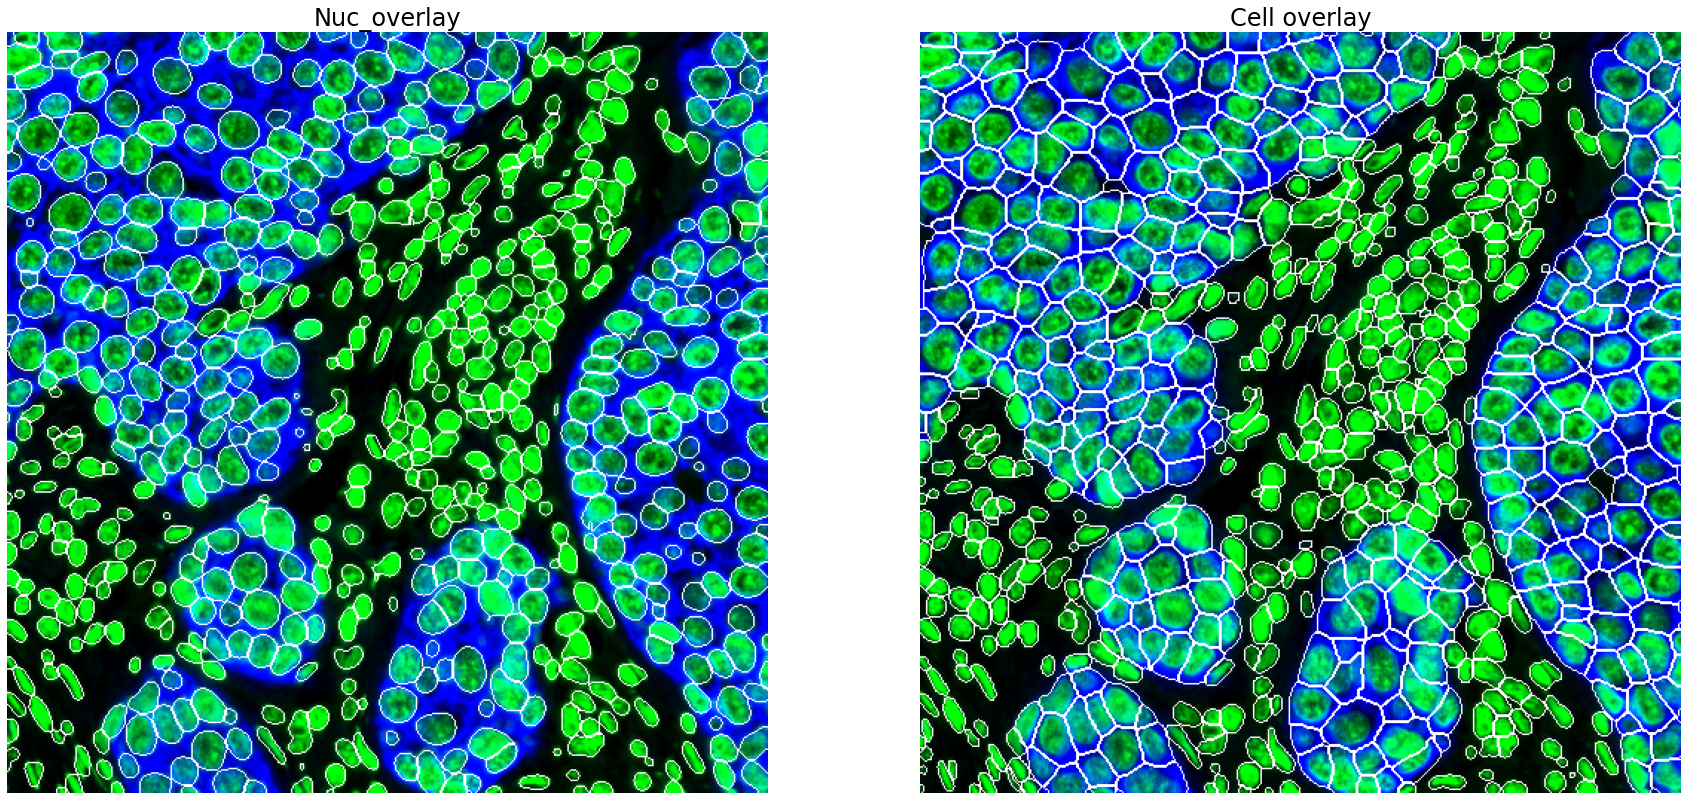

In [81]:
# check that each tranche matches up with correct labels
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay
import matplotlib.pyplot as plt
idx = 2600
rgb_data = create_rgb_image(X_train[idx:idx + 1], ['green', 'blue'])
nuc_overlay = make_outline_overlay(rgb_data, predictions[idx:idx + 1, ..., :1])
cell_overlay = make_outline_overlay(rgb_data, y_train[idx:idx + 1, ..., :1])

cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 0
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(nuc_overlay[index,...])
axes[1].imshow(cell_overlay[index, ...], cmap=cmap)

axes[0].set_title('Nuc_overlay', fontsize=24)
axes[1].set_title('Cell overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [82]:
np.savez_compressed(os.path.join(NPZ_DIR, npz_name + 'nuclear_train_512x512.npz'), 
         X=X_train, 
         y=np.concatenate((y_train, predictions), axis=-1))

In [83]:
# val data
inner_distance, pixelwise = model.predict(X_val)

predictions = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.1, maxima_model_smooth=0,
                                  interior_threshold=0.3,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,
                                   pixel_expansion=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  if __name__ == '__main__':


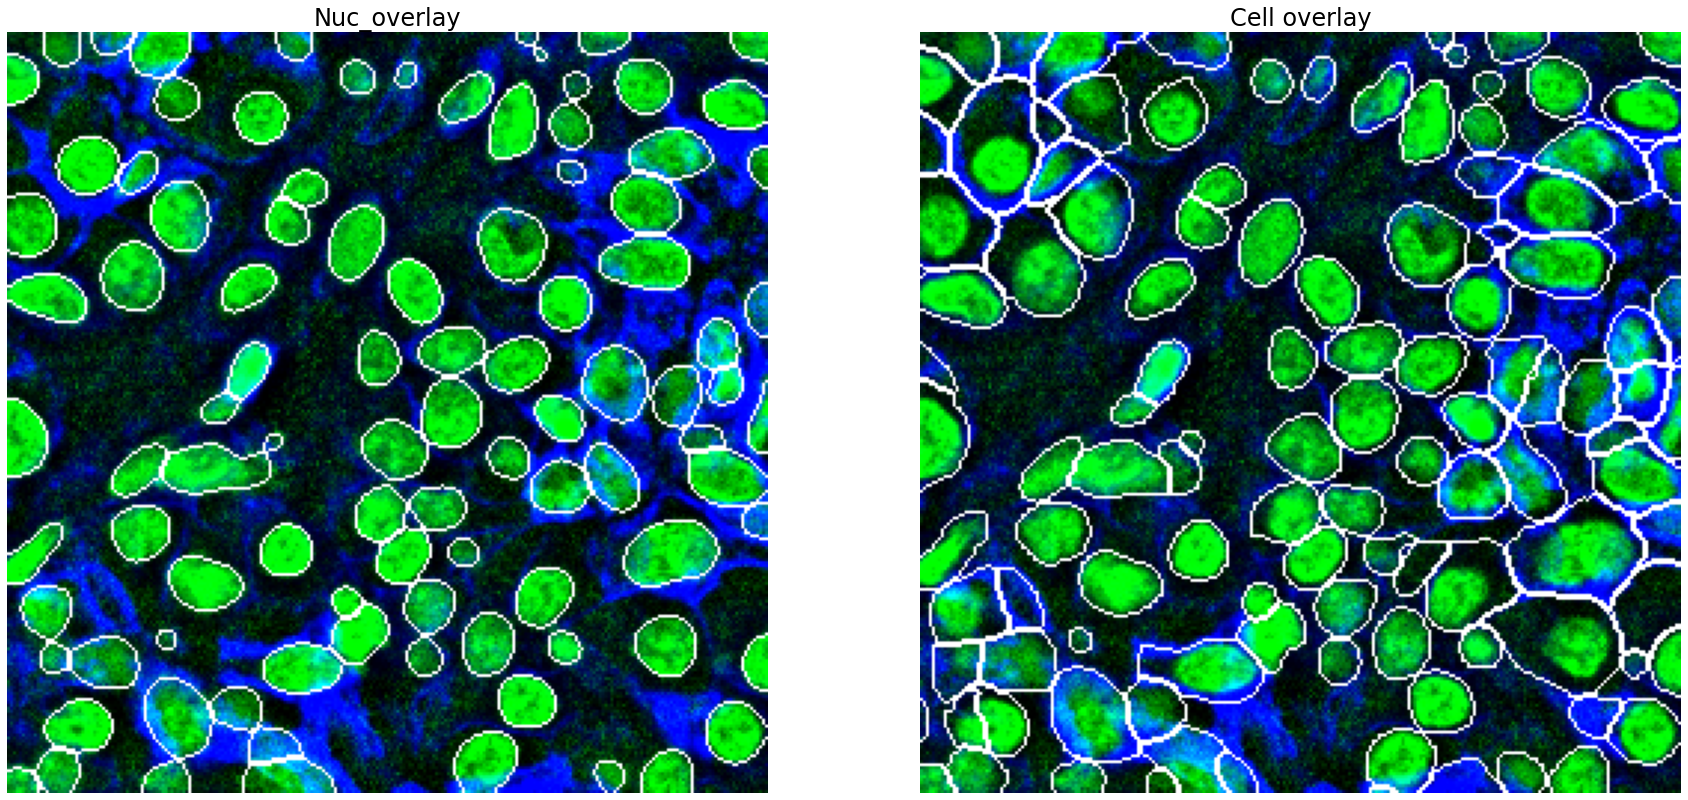

In [84]:
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay
import matplotlib.pyplot as plt
idx = 200
rgb_data = create_rgb_image(X_val[idx:idx + 1], ['green', 'blue'])
nuc_overlay = make_outline_overlay(rgb_data, predictions[idx:idx + 1, ..., :1])
cell_overlay = make_outline_overlay(rgb_data, y_val[idx:idx + 1, ..., :1])

cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 0
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(nuc_overlay[index,...])
axes[1].imshow(cell_overlay[index, ...], cmap=cmap)

axes[0].set_title('Nuc_overlay', fontsize=24)
axes[1].set_title('Cell overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [85]:
np.savez_compressed(os.path.join(NPZ_DIR, npz_name + 'nuclear_val_256x256.npz'), 
         X=X_val, 
         y=np.concatenate((y_val, predictions), axis=-1))

In [86]:
# test data
inner_distance, pixelwise = model.predict(X_test)

predictions = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.1, maxima_model_smooth=0,
                                  interior_threshold=0.3,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,
                                   pixel_expansion=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  if __name__ == '__main__':


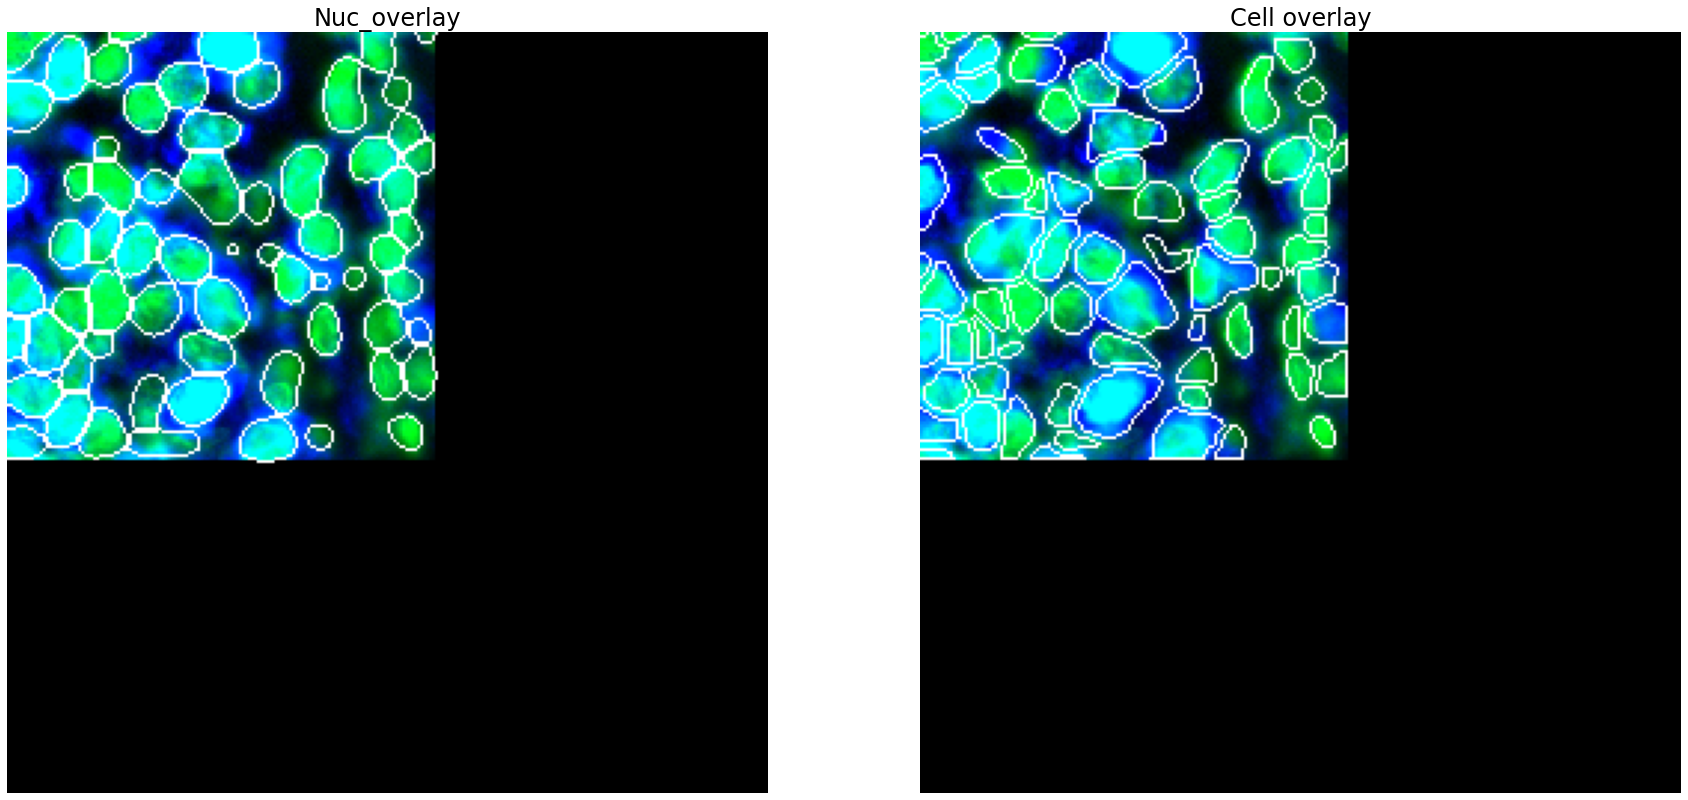

In [87]:
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay
import matplotlib.pyplot as plt
idx = 900
rgb_data = create_rgb_image(X_test[idx:idx + 1], ['green', 'blue'])
nuc_overlay = make_outline_overlay(rgb_data, predictions[idx:idx + 1, ..., :1])
cell_overlay = make_outline_overlay(rgb_data, y_test[idx:idx + 1, ..., :1])

cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 0
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(nuc_overlay[index,...])
axes[1].imshow(cell_overlay[index, ...], cmap=cmap)

axes[0].set_title('Nuc_overlay', fontsize=24)
axes[1].set_title('Cell overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [88]:
np.savez_compressed(os.path.join(NPZ_DIR, npz_name + 'nuclear_test_256x256.npz'), 
         X=X_test, 
         y=np.concatenate((y_test, predictions), axis=-1))